In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import tree
import os

from pathlib import Path
import xarray as xa
from xhistogram.xarray import histogram

from began import rotate, flip
from began import Encoder, Decoder, VQVAEModel, ResidualStack

try:
    import sonnet.v2 as snt
    tf.enable_v2_behavior()
except ImportError:
    import sonnet as snt

print("TensorFlow version {}".format(tf.__version__))
print("Sonnet version {}".format(snt.__version__))

TensorFlow version 2.1.0
Sonnet version 2.0.0


In [2]:
def check_directories(root_dir, name):
    root_dir = Path(root_dir).absolute()
    try:
        assert root_dir.exists()
    except AssertionError:
        raise AssertionError("Root dir must exist")
    directories = [root_dir]
    for sub in ['models', 'plots', 'data']:
        subdir = root_dir / sub / name
        subdir.mkdir(exist_ok=True)
        directories.append(subdir)
    return directories

def load_cfg(cfg_path):
    with open(cfg_path) as f:
        cfg = yaml.load(f, Loader=yaml.FullLoader)
    return cfg['data'], cfg['training'], cfg['loss'], cfg['architecture'], Path(cfg['name'])

In [ ]:
data_dir = Path("/oasis/scratch/comet/bthorne/temp_project/began_scratch/mhd/mhd_temp/data")
    
train_fpath = data_dir / "mhd_ntrain-3150.cdf"
test_fpath = data_dir / "mhd_ntest-0300.cdf"

train_images = xa.open_dataarray(train_fpath).sel(pol=['t']).transpose('batch', ..., 'pol').values.astype(np.float32)
test_images = xa.open_dataarray(test_fpath).sel(pol=['t']).transpose('batch', ..., 'pol').values.astype(np.float32)

channels = train_images.shape[-1]

In [ ]:
checkpoint_root = "/oasis/scratch/comet/bthorne/temp_project/began_scratch/mhd/checkpoints"
checkpoint_name = "example"
save_prefix = os.path.join(checkpoint_root, checkpoint_name)


In [ ]:
train_data_variance = np.var(train_images)
print('train data variance: %s' % train_data_variance)

In [ ]:
%%time

# Set hyper-parameters.
batch_size = 32
image_size = 256

# 100k steps should take < 30 minutes on a modern (>= 2017) GPU.
# 10k steps gives reasonable accuracy with VQVAE on Cifar10.
num_training_updates = 20000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2
# These hyper-parameters define the size of the model (number of parameters and layers).
# The hyper-parameters in the paper were (For ImageNet):
# batch_size = 128
# image_size = 128
# num_hiddens = 128
# num_residual_hiddens = 32
# num_residual_layers = 2

# This value is not that important, usually 64 works.
# This will not change the capacity in the information-bottleneck.
embedding_dim = 64

# The higher this value, the higher the capacity in the information bottleneck.
#num_embeddings = 512
num_embeddings = 512

# commitment_cost should be set appropriately. It's often useful to try a couple
# of values. It mostly depends on the scale of the reconstruction cost
# (log p(x|z)). So if the reconstruction cost is 100x higher, the
# commitment_cost should also be multiplied with the same amount.
commitment_cost = 0.25

# Use EMA updates for the codebook (instead of the Adam optimizer).
# This typically converges faster, and makes the model less dependent on choice
# of the optimizer. In the VQ-VAE paper EMA updates were not used (but was
# developed afterwards). See Appendix of the paper for more details.
vq_use_ema = True

# This is only used for EMA updates.
decay = 0.99

learning_rate = 3e-4

train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_images.shape[0])
                 .map(rotate, num_parallel_calls=4)
                 .map(flip, num_parallel_calls=4)
                 .repeat(-1)
                 .batch(batch_size)
                 .prefetch(-1))

valid_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .repeat(1)  # 1 epoch
    .batch(batch_size)
    .prefetch(-1))

# # Build modules.
encoder = Encoder(num_hiddens, num_residual_layers, num_residual_hiddens)
decoder = Decoder(num_hiddens, num_residual_layers, num_residual_hiddens, channels=channels)
pre_vq_conv1 = snt.Conv2D(output_channels=embedding_dim,
    kernel_shape=(1, 1),
    stride=(1, 1),
    name="to_vq")

if vq_use_ema:
    vq_vae = snt.nets.VectorQuantizerEMA(
        embedding_dim=embedding_dim,
        num_embeddings=num_embeddings,
        commitment_cost=commitment_cost,
        decay=decay)
else:
    vq_vae = snt.nets.VectorQuantizer(
        embedding_dim=embedding_dim,
        num_embeddings=num_embeddings,
        commitment_cost=commitment_cost)
    
model = VQVAEModel(encoder, decoder, vq_vae, pre_vq_conv1,
                   data_variance=train_data_variance)

chkpt = tf.train.Checkpoint(module=model)


optimizer = snt.optimizers.Adam(learning_rate=learning_rate)

@tf.function
def train_step(data):
    with tf.GradientTape() as tape:
        model_output = model(data, is_training=True)
    trainable_variables = model.trainable_variables
    grads = tape.gradient(model_output['loss'], trainable_variables)
    optimizer.apply(grads, trainable_variables)
    return model_output

train_losses = []
train_recon_errors = []
train_perplexities = []
train_vqvae_loss = []

latest = tf.train.latest_checkpoint(checkpoint_root)
if latest is not None:
    chkpt.restore(latest)

In [35]:
for step_index, data in enumerate(train_dataset):
    train_results = train_step(data)
    train_losses.append(train_results['loss'])
    train_recon_errors.append(train_results['recon_error'])
    train_perplexities.append(train_results['vq_output']['perplexity'])
    train_vqvae_loss.append(train_results['vq_output']['loss'])

    if (step_index + 1) % 100 == 0:
        print('%d train loss: %f ' % (step_index + 1,
                                   np.mean(train_losses[-100:])) +
          ('recon_error: %.3f ' % np.mean(train_recon_errors[-100:])) +
          ('perplexity: %.3f ' % np.mean(train_perplexities[-100:])) +
          ('vqvae loss: %.3f' % np.mean(train_vqvae_loss[-100:])))

    if step_index and not step_index % 1000:
        chkpt.save(save_prefix)
        
    if step_index == num_training_updates:
        break

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function train_step at 0x2b654ff175f0>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function train_step at 0x2b654ff175f0>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source

In [101]:
chkpt.save(save_prefix)

'/oasis/scratch/comet/bthorne/temp_project/began_scratch/mhd/checkpoints/example-1'

Text(0.5, 1.0, 'Average codebook usage (perplexity).')

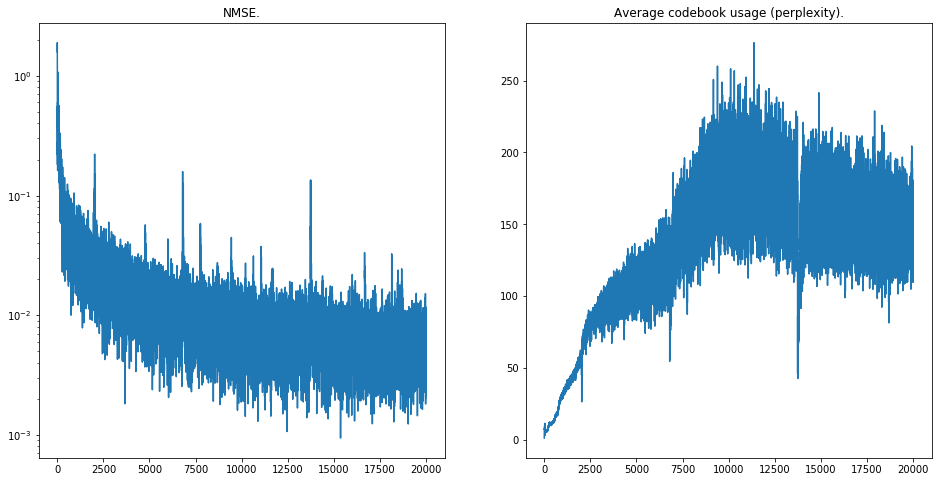

In [36]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_recon_errors)
ax.set_yscale('log')
ax.set_title('NMSE.')

ax = f.add_subplot(1,2,2)
ax.plot(train_perplexities)
ax.set_title('Average codebook usage (perplexity).')

In [10]:
# Reconstructions
train_batch = next(iter(train_dataset))
valid_batch = next(iter(valid_dataset))

# Put data through the model with is_training=False, so that in the case of 
# using EMA the codebook is not updated.
train_reconstructions = model(train_batch,
                              is_training=False)['x_recon'].numpy()
valid_reconstructions = model(valid_batch,
                              is_training=False)['x_recon'].numpy()

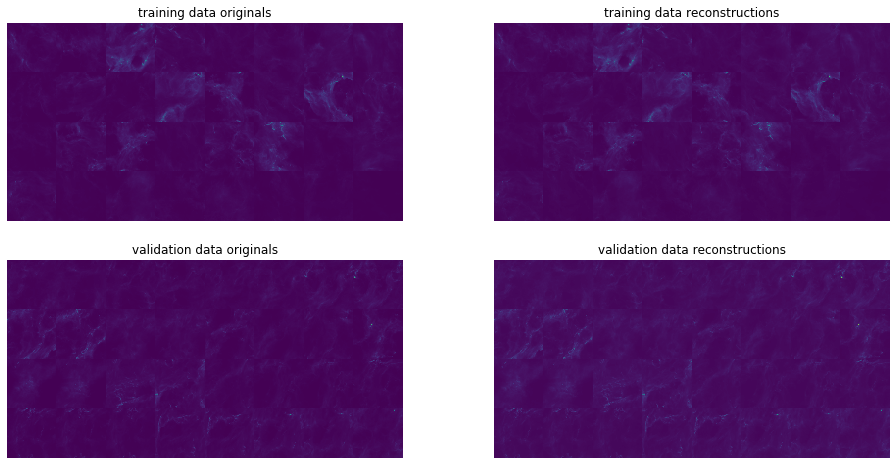

In [11]:
def convert_batch_to_image_grid(image_batch):
    reshaped = (image_batch.reshape(4, 8, 256, 256, 1)
              .transpose(0, 2, 1, 3, 4)
              .reshape(4 * 256, 8 * 256))
    return reshaped + 0.5



f = plt.figure(figsize=(16,8))
ax = f.add_subplot(2,2,1)
ax.imshow(convert_batch_to_image_grid(train_batch.numpy()),
          interpolation='nearest')
ax.set_title('training data originals')
plt.axis('off')

ax = f.add_subplot(2,2,2)
ax.imshow(convert_batch_to_image_grid(train_reconstructions),
          interpolation='nearest')
ax.set_title('training data reconstructions')
plt.axis('off')

ax = f.add_subplot(2,2,3)
ax.imshow(convert_batch_to_image_grid(valid_batch.numpy()),
          interpolation='nearest')
ax.set_title('validation data originals')
plt.axis('off')

ax = f.add_subplot(2,2,4)
ax.imshow(convert_batch_to_image_grid(valid_reconstructions),
          interpolation='nearest')
ax.set_title('validation data reconstructions')
plt.axis('off')
f.savefig('vqvae.pdf', bbox_inches='tight')

In [12]:
nsamp = 32
dims = ['batch', 'x', 'y', 'pol']    
coords = {
    'batch': np.arange(nsamp),
    'x': np.arange(256),
    'y': np.arange(256),
    'pol': ['t']
}

recon = xa.DataArray(valid_reconstructions, coords=coords, dims=dims, name='recon')
test = xa.DataArray(valid_batch, coords=coords, dims=dims, name='test')

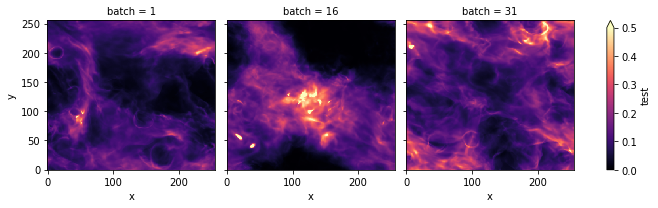

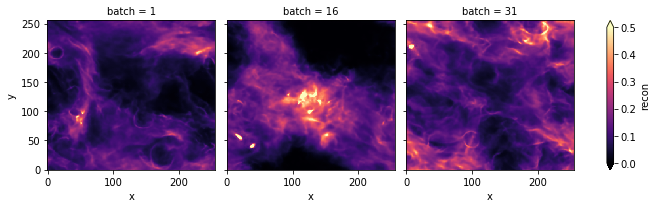

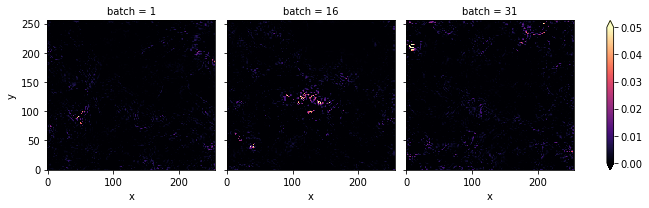

In [45]:
residuals = recon - test

vmin = 0.
vmax= 0.5
batch_idx = [1, 16, 31]
cmap = 'magma'

test.sel(batch=batch_idx, pol='t').plot.pcolormesh('x', 'y', col_wrap=3, col='batch', cmap=cmap, vmin=vmin, vmax=vmax)
recon.sel(batch=batch_idx, pol='t').plot.pcolormesh('x', 'y', col_wrap=3, col='batch', cmap=cmap, vmin=vmin, vmax=vmax)
residuals.sel(batch=batch_idx, pol='t').plot.pcolormesh('x', 'y', col_wrap=3, col='batch', cmap=cmap, vmin=vmin/10., vmax=vmax/10.)

In [14]:
vmin = -0.04
vmax=0.04

test.sel(batch=batch_idx, pol='u').plot.pcolormesh('x', 'y', col_wrap=3, col='batch', cmap='cividis', vmin=vmin, vmax=vmax)
recon.sel(batch=batch_idx, pol='u').plot.pcolormesh('x', 'y', col_wrap=3, col='batch', cmap='cividis', vmin=vmin, vmax=vmax)
residuals.sel(batch=batch_idx, pol='u').plot.pcolormesh('x', 'y', col_wrap=3, col='batch', cmap='cividis', vmin=vmin, vmax=vmax)

KeyError: 'u'

In [44]:
from began import make_square_mask, make_flat_bins, apply_nmt_flat
import pymaster as nmt
nx = 256
ny = 256
theta = 29.
ang = np.radians(theta)
mask = make_square_mask(nx, ny, ang)
binning = make_flat_bins(ang, nx, 8)

wsp00 = nmt.NmtWorkspaceFlat()
#wsp02 = nmt.NmtWorkspaceFlat()
#wsp22 = nmt.NmtWorkspaceFlat()

f0 = nmt.NmtFieldFlat(ang, ang, mask, np.random.randn(1, nx, nx))
f2 = nmt.NmtFieldFlat(ang, ang, mask, np.random.randn(2, nx, nx), purify_e=True, purify_b=True)

wsp00.compute_coupling_matrix(f0, f0, binning)
#wsp02.compute_coupling_matrix(f0, f2, binning)
#wsp22.compute_coupling_matrix(f2, f2, binning)

recon_cl = apply_nmt_flat(recon, mask, ang, binning, wsp00=wsp00)
recon_cl_mean = recon_cl.mean(dim='batch')
recon_cl_std = recon_cl.std(dim='batch')

In [45]:
data_dir = Path("/oasis/scratch/comet/bthorne/temp_project/began_scratch/mhd/mhd_temp/data")

test_cl = apply_nmt_flat(test, mask, ang, binning, wsp00=wsp00)

In [46]:
test_cl_mean = test_cl.mean(dim='batch')
test_cl_std = test_cl.std(dim='batch')

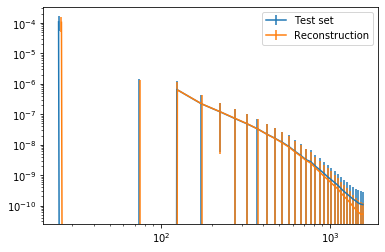

In [47]:
fig, ax = plt.subplots(1, 1)
sel = {
    'field': 'tt'
}
ax.errorbar(test_cl.bandpowers, test_cl_mean.sel(**sel), test_cl_std.sel(**sel), label='Test set')
ax.errorbar(recon_cl.bandpowers+1, recon_cl_mean.sel(**sel), recon_cl_std.sel(**sel), label='Reconstruction')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()

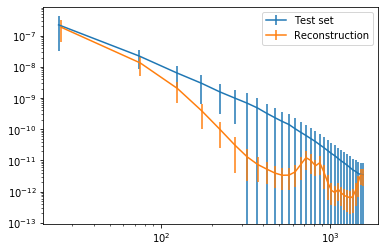

In [16]:
fig, ax = plt.subplots(1, 1)
sel = {
    'field': 'bb'
}
ax.errorbar(test_cl.bandpowers, test_cl_mean.sel(**sel), test_cl_std.sel(**sel), label='Test set')
ax.errorbar(recon_cl.bandpowers+1, recon_cl_mean.sel(**sel), recon_cl_std.sel(**sel), label='Reconstruction')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()

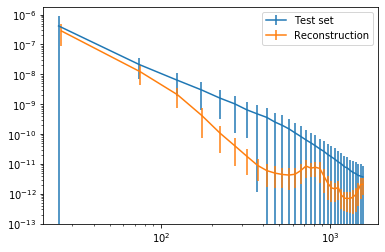

In [17]:
fig, ax = plt.subplots(1, 1)
sel = {
    'field': 'ee'
}
ax.errorbar(test_cl.bandpowers, test_cl_mean.sel(**sel), test_cl_std.sel(**sel), label='Test set')
ax.errorbar(recon_cl.bandpowers+1, recon_cl_mean.sel(**sel), recon_cl_std.sel(**sel), label='Reconstruction')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()

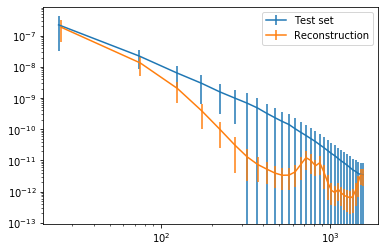

In [18]:
fig, ax = plt.subplots(1, 1)
sel = {
    'field': 'bb'
}
ax.errorbar(test_cl.bandpowers, test_cl_mean.sel(**sel), test_cl_std.sel(**sel), label='Test set')
ax.errorbar(recon_cl.bandpowers+1, recon_cl_mean.sel(**sel), recon_cl_std.sel(**sel), label='Reconstruction')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()

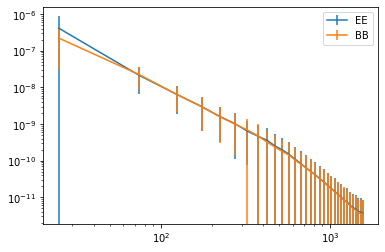

In [19]:
fig, ax = plt.subplots(1, 1)
ax.errorbar(test_cl.bandpowers, test_cl_mean.sel(field='ee'), test_cl_std.sel(field='ee'), label='EE')
ax.errorbar(test_cl.bandpowers, test_cl_mean.sel(field='bb'), test_cl_std.sel(field='bb'), label='BB')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()

(100, 1500)

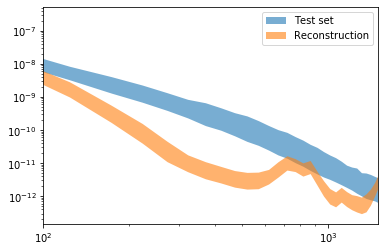

In [20]:
test_quantiles = test_cl.quantile([0.25, 0.75], 'batch').sel(**sel)
recon_quantiles = recon_cl.quantile([0.27, 0.75], 'batch').sel(**sel)
fig, ax = plt.subplots(1, 1)
ax.fill_between(test_quantiles.bandpowers, test_quantiles.isel(quantile=0), test_quantiles.isel(quantile=1), alpha=0.6, label='Test set')
ax.fill_between(recon_quantiles.bandpowers, recon_quantiles.isel(quantile=0), recon_quantiles.isel(quantile=1), alpha=0.6, label='Reconstruction')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
ax.set_xlim(100, 1500)
#ax.set_ylim(1e-9, 1e-3)

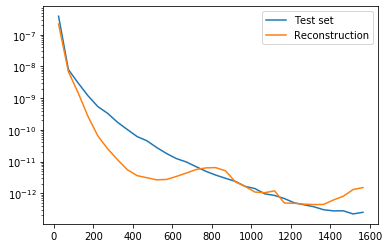

In [21]:
sel = {
    'batch': 20,
    'field': 'ee'
}
fig, ax = plt.subplots(1, 1)
ax.plot(test_cl.bandpowers, test_cl.sel(**sel), label='Test set')
ax.plot(recon_cl.bandpowers, recon_cl.sel(**sel), label='Reconstruction')
ax.set_yscale('log')
ax.legend()

In [53]:
bins = np.linspace(vmin, vmax, 50)
from began import resample_iterations

In [54]:
recon_hist = histogram(recon, bins=[bins], dim=['x', 'y'])

In [55]:
test_hist = histogram(test, bins=[bins], dim=['x', 'y'])

In [56]:
resampled_test_images = resample_iterations(test, 50, dim='batch')
resampled_recon_images = resample_iterations(recon, 50, dim='batch')

In [58]:
test_bin_iqr = histogram(resampled_test_images, bins=[bins], dim=['x', 'y']).median(dim='batch').quantile([0.25, 0.75], 'iteration').sel(pol='t')
recon_bin_iqr = histogram(resampled_recon_images, bins=[bins], dim=['x', 'y']).median(dim='batch').quantile([0.25, 0.75], 'iteration').sel(pol='t')

Text(0.5, 1.0, 'Interquartile range of pixel histogram')

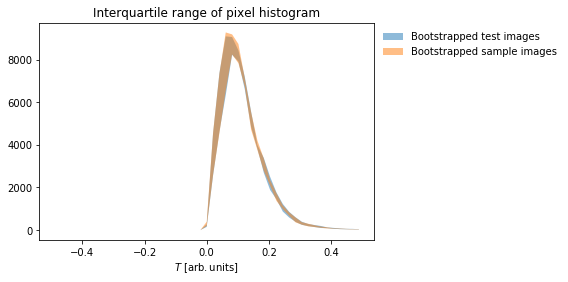

In [59]:
fig, ax = plt.subplots(1, 1)
ax.fill_between(test_bin_iqr.test_bin, test_bin_iqr.sel(quantile=0.25), test_bin_iqr.sel(quantile=0.75), label='Bootstrapped test images', alpha=0.5)
ax.fill_between(recon_bin_iqr.recon_bin, recon_bin_iqr.sel(quantile=0.25), recon_bin_iqr.sel(quantile=0.75), label='Bootstrapped sample images', alpha=0.5)
ax.legend(loc='upper left', bbox_to_anchor=(1., 1.), frameon=False)
ax.set_label(r"Density")
ax.set_xlabel(r"$T~{\rm [arb. units]}$")
ax.set_title("Interquartile range of pixel histogram")

In [32]:
planck_maps = xa.open_dataarray("/oasis/scratch/comet/bthorne/temp_project/began_scratch/mhd/mhd_temp/data/planck_cutouts_30deg.cdf")

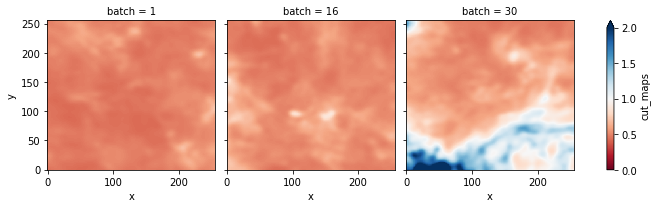

In [38]:

vmin = 0
vmax = 2
batch_idx = [1, 16, 30]
planck_maps.sel(batch=batch_idx, pol='t').plot.pcolormesh('x', 'y', col_wrap=3, col='batch', cmap="RdBu", vmin=vmin, vmax=vmax)

In [90]:
planck_maps.values[:nsamp].shape

(32, 256, 256, 1)

In [91]:
planck_reconstructions = model(planck_maps.values[:nsamp].astype(np.float32), is_training=False)['x_recon'].numpy()
planck_recon = xa.DataArray(planck_reconstructions, coords=coords, dims=dims, name='recon')

In [39]:
planck_recon.sel(batch=batch_idx, pol='t').plot.pcolormesh('x', 'y', col_wrap=3, col='batch', cmap='RdBu', vmin=vmin, vmax=vmax)

NameError: name 'planck_recon' is not defined

In [93]:
planck_residuals = planck_maps - planck_recon

In [35]:
planck_residuals.sel(batch=batch_idx, pol='t').plot.pcolormesh('x', 'y', col_wrap=3, col='batch', vmin=-0.1, vmax=0.1)

NameError: name 'planck_residuals' is not defined

In [95]:
planck_recon_cl = apply_nmt_flat(planck_recon, mask, ang, binning, wsp00=wsp00)
planck_cl = apply_nmt_flat(planck_maps, mask, ang, binning, wsp00=wsp00)

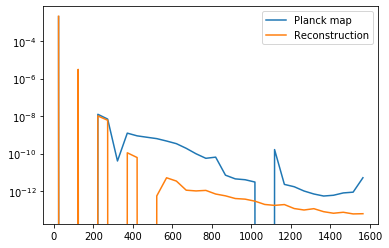

In [96]:
sel = {
    'batch': 10,
    'field': 'tt'
}
fig, ax = plt.subplots(1, 1)
ax.plot(planck_recon_cl.bandpowers, planck_recon_cl.sel(**sel), label='Planck map')
ax.plot(planck_cl.bandpowers, planck_cl.sel(**sel), label='Reconstruction')
ax.set_yscale('log')
ax.legend()

In [15]:
tf.saved_model.save(model, "/oasis/scratch/comet/bthorne/temp_project/began_scratch/mhd/mhd_temp/vaevq.h5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /oasis/scratch/comet/bthorne/temp_project/began_scratch/mhd/mhd_temp/vaevq.h5/assets


In [23]:
load_model= tf.saved_model.load("/oasis/scratch/comet/bthorne/temp_project/began_scratch/mhd/mhd_temp/vaevq.h5")

In [25]:
planck_reconstructions = load_model(planck_maps.values[:nsamp].astype(np.float32), is_training=False)['x_recon']


TypeError: '_UserObject' object is not callable

In [26]:
load_model

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x2b4e4aea8490>

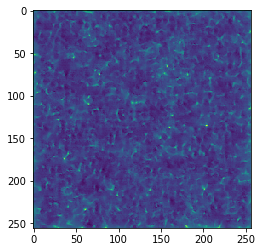

In [34]:
plt.imshow(model(tf.random.normal((1, 256, 256, 1)), is_training=False)['x_recon'][0, :, :, 0])

In [48]:
@tf.function(input_signature=[tf.TensorSpec([None, 256, 256, 1])])
def inference(x):
    return model(x, is_training=False)

to_save = snt.Module()
to_save.inference = inference
to_save.all_variables = list(model.variables)
tf.saved_model.save(to_save, "/oasis/scratch/comet/bthorne/temp_project/began_scratch/mhd/mhd_temp/vqvae-saved")

INFO:tensorflow:Assets written to: /oasis/scratch/comet/bthorne/temp_project/began_scratch/mhd/mhd_temp/vqvae-saved/assets


In [67]:
loaded = tf.saved_model.load("/oasis/scratch/comet/bthorne/temp_project/began_scratch/mhd/mhd_temp/vqvae-saved")
code = loaded.inference(planck_maps.values)

In [68]:
batch_idx = [1, 20, 100]

In [69]:
nsamp = 32
dims = ['batch', 'x', 'y', 'pol']    
coords = {
    'batch': np.arange(nsamp),
    'x': np.arange(256),
    'y': np.arange(256),
    'pol': ['t']
}

recon = xa.DataArray(valid_reconstructions, coords=coords, dims=dims, name='recon')
test = xa.DataArray(valid_batch, coords=coords, dims=dims, name='test')

NameError: name 'valid_reconstructions' is not defined

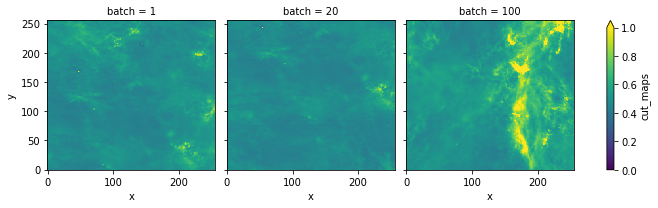

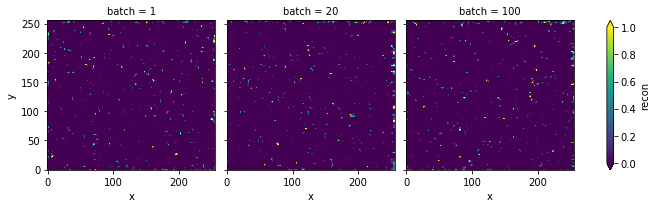

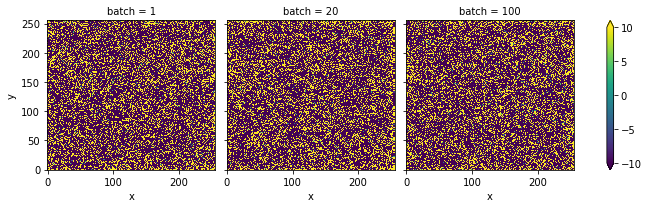

In [66]:
vmin=0
vmax=1
planck_maps.sel(batch=batch_idx, pol='t').plot.pcolormesh('x', 'y', col_wrap=3, col='batch', robust=True, vmin=vmin, vmax=vmax)
recon.sel(batch=batch_idx, pol='t').plot.pcolormesh('x', 'y', col_wrap=3, col='batch', robust=True, vmin=vmin, vmax=vmax)
residuals.sel(batch=batch_idx, pol='t').plot.pcolormesh('x', 'y', col_wrap=3, col='batch', robust=True, vmin=-10, vmax=10)
